<a href="https://colab.research.google.com/github/gil612/PyTorch/blob/main/08_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. Milestone Project 2: PyTorch Paper Replicating

The goal of Machine Learning research paper replicating is tuen a ML research paper into a usable code.

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture/paper with PyTorch: https://arxiv.org/abs/2010.11929

## 0. Get Setup

Let's import code we've previously written + required libraries

In [95]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu121
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")



[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://download.pytorch.org/whl/nightly/cu121
torch version: 2.3.1+cu121
torchvision version: 0.18.1+cu121


In [96]:
import requests
from pathlib import Path


if Path("helper_functions.py").is_file():
  print()
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/gil612/PyTorch/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [97]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [98]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

The whole goal of what we're trying to do is to replicate the ViT arcitecture for our FoodVision Mini problem.

To do that, we need some data.

Namely, the pizza, steak an sushi images we've been using so far.

In [99]:
import os
import zipfile

from pathlib import Path

import requests



def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """ """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path /destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
      print(f"[INFO] {image_path} directory already exists... skipping download")
    else:
      print(f"[INFO] {image_path} does not exist, creating one...")
      image_path.mkdir(parents=True, exist_ok=True)

    # Download the target data
    target_file = Path(source).name
    with open(data_path / target_file, "wb") as f:
      request = requests.get(source)
      print(f"[INFO] Downloading {target_file} from {source}...")
      f.write(request.content)

    # Unzip target_file
    with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
      print(f"[INFO] Unzipping {target_file} data...")
      zip_ref.extractall(image_path)

    # Remove .zip file if needed
    if remove_source:
      os.remove(data_path / target_file)

    return image_path

In [100]:
image_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination = "pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory already exists... skipping download
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [101]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [102]:
from going_modular.going_modular import data_setup

# Create image size
IMG_SIZE = 224 # comes from table 3 of the ViT paper

# Create transform pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f"Maually created tranforms: {manual_transforms}")

Maually created tranforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [103]:
# Create a bathc size of 32 (the paper uses 4096 but this may be too big for our sma)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size = BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

As always, let's adhere the motto, *visualize, visuzalize, visualize!*

In [104]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image ans label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

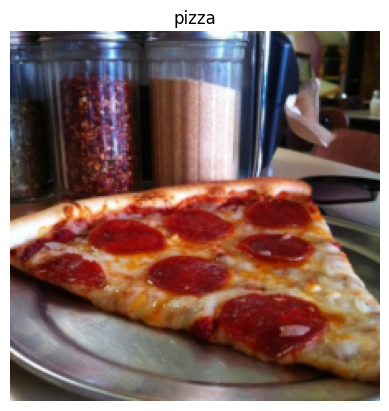

In [105]:
# Plot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

##3. Replicating ViT: Overview

Looking at awhole machine learning research paper can ber intimidating.

So in order to make it more understandable, we can break it down into smaller pieces:

* **Inputs** - What goes into the model? (in our case, image tensors)
* **Outputs** - What comes out of the model/layer/block? (in our case, we want the model to output image classifiaction labels)
* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention
* **Blocks** - A collection of layers
* **Model (or architecture)** - A collection of blocks.

### 3.1 ViT overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* 4 equation: math equations which define the functions of each layer/block
* Table 1/3: different hyperparameters for the architecture/training

### Figure 1

<img src="https://i.imgur.com/2tKxTGx.png" width=600 alt="figure 1 from vision transformer paper"/>

* Embedding - learnable representation (start with random numbers and improve over time)
* Learnable = embedding  classification token to the sequence.
* Multi layer Percepetron (MLP) - a stack of a couple on top each other. Number of layers could couldbe arbitrary.

### Four equations
<img src="https://i.imgur.com/4iNsK3i.png" width=600 alt="r"/>

z is a residual connection
* Residual connection - A [residual connection](https://www.kaggle.com/code/residentmario/notes-on-residual-connections) connects the output of one earlier convolutional layer to the input of another future convolutional layer several layers later (e.g. a numer of intermediate convolutional steps are skipped). The input of the mainstream model and the input of the convolutional prior are combined using a simple sum.


### Table 1
<img src="https://i.imgur.com/8f2T2ye.png" width=600 alt=""/>


## 4. Equation 1: Split data into patches and creating class , posituin and patch embeddings

Layers = input -> function -> output

What's the unput shape?

What's the output shape?



### 4.1

* Input shape: $\mathbf{N} \times W \times C$ (height x width x color channels)
* Output shape $\mathbf{N} \times (P^2 \cdot C)$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / p^2
* D = Constant latent vector size = embedding dimension (see Table 1)

In [106]:
## Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width / patch_size **2))
number_of_patches

196

In [107]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


### 4.2 Turning a single image into patches

(-0.5, 223.5, 223.5, -0.5)

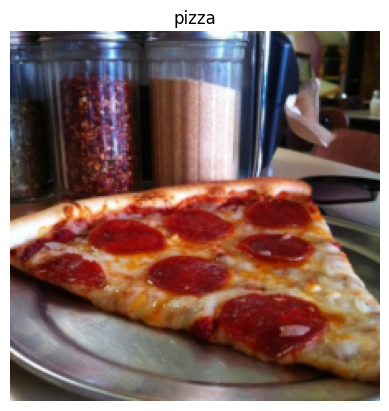

In [108]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [109]:
image.shape

torch.Size([3, 224, 224])

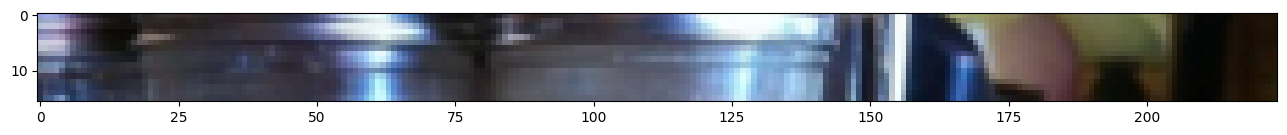

In [110]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # convert image to color channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize = (patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row:14.01616


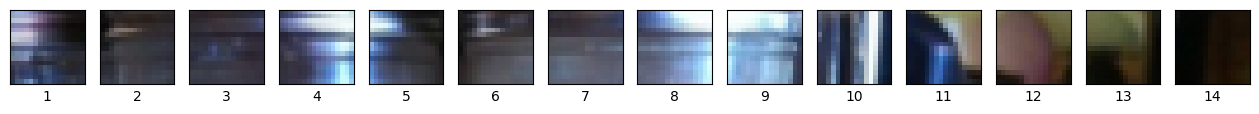

In [111]:
# Setup code to plot top row as patchesh
img_size = 224
patch_size = 16
num_patches = img_size/patch_size


#---------------------------------------------------------------------

assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row:{num_patches}{patch_size}{patch_size}")

# Create a series  of subplots
fig, axs = plt.subplots(nrows = 1,
                       ncols = img_size // patch_size, # one columnn for each patch
                       sharex = True,
                       sharey = True,
                        figsize=(patch_size, patch_size)
                       )

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

In [112]:
img_size, patch_size

(224, 16)

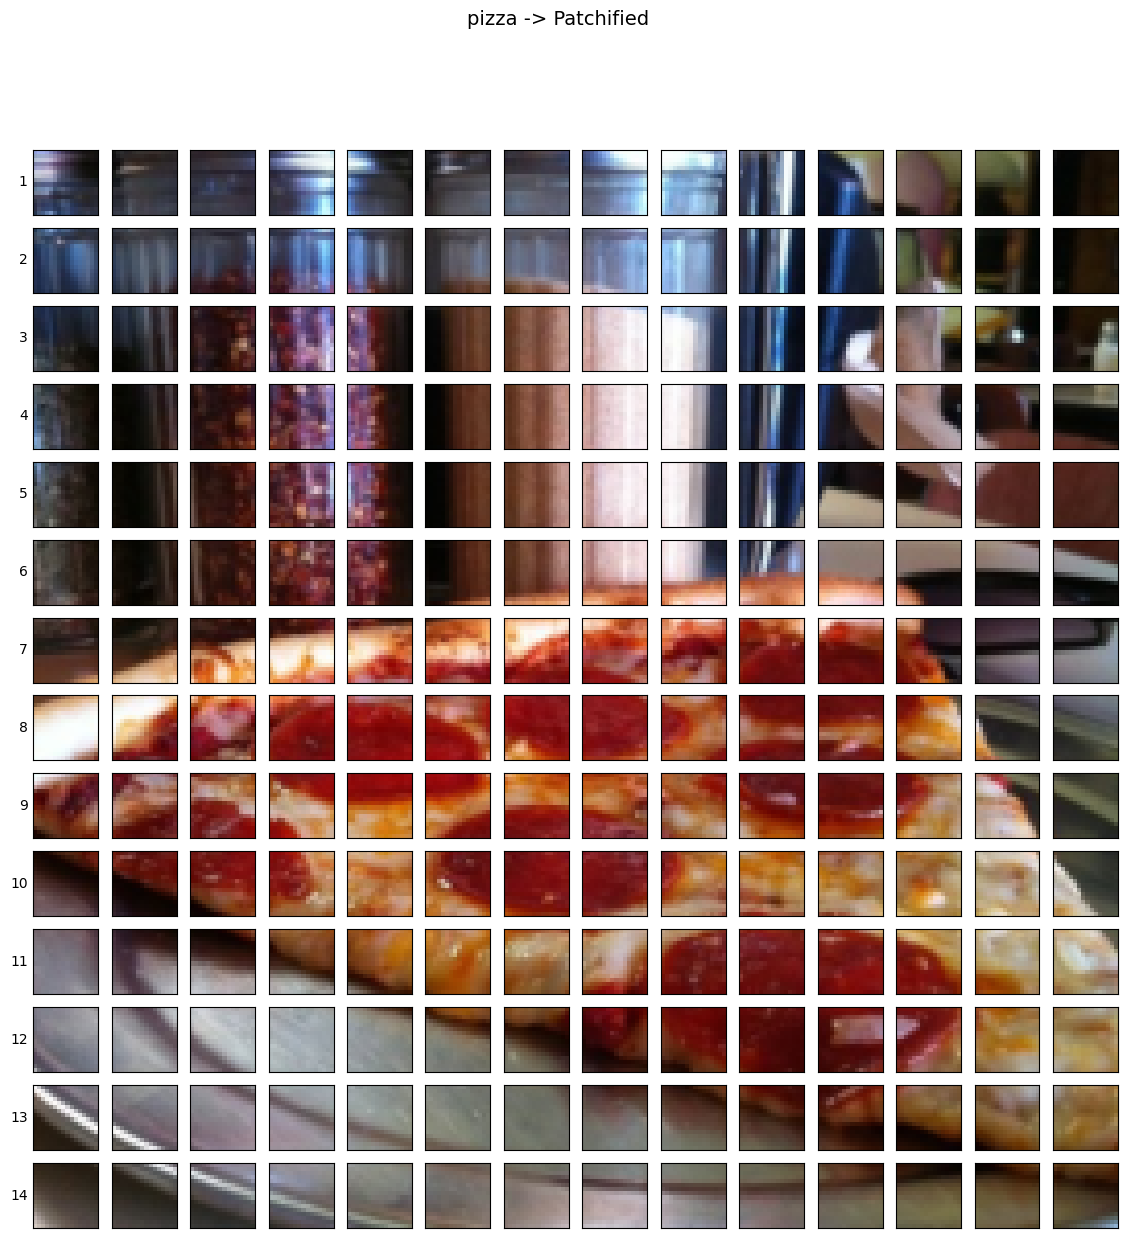

In [113]:
# Setup to plot whole image as patches
nrows = img_size // patch_size
ncols = img_size // patch_size
num_patches = img_size/patch_size


# Create a series  of subplots
fig, axs = plt.subplots(nrows = nrows,
                       ncols = ncols, # one columnn for each patch
                       sharex = True,
                       sharey = True,
                        figsize=(num_patches, num_patches)
                       )
for i, patch_height in enumerate(range(0, img_size, patch_size)):
  # print(j)
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    # print(i, patch)
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                    patch_width:patch_width+patch_size,
                                    :]);
    axs[i, j].set_ylabel(i+1,
                         rotation = "horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Set up a title the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize = 14)
plt.show()

In [114]:
# # Setup to plot whole image as patches
# nrows = img_size // patch_size
# ncols = img_size // patch_size
# num_patches = img_size/patch_size
# Create a series  of subplots
# fig, axs = plt.subplots(nrows = nrows,
#                        ncols = ncols, # one columnn for each patch
#                        sharex = True,
#                        sharey = True,
#                         figsize=(num_patches, num_patches)
#                        )
# for i, patch_height in enumerate(range(0, img_size, patch_size)):
#   # print(j)
#   for j, patch_width in enumerate(range(0, img_size, patch_size)):
#     print(i, j, patch_height, patch_width)
#     axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
#                                     patch_width:patch_width+patch_size,
#                                     :]);
#     axs[i, j].set_ylabel(i+1,
#                          rotation = "horizontal",
#                          horizontalalignment="right",
#                          verticalalignment="center")
#     axs[i, j].set_xticks([])
#     axs[i, j].set_yticks([])
#     axs[i, j].label_outer()

# # Set up a title the plot
# fig.suptitle(f"{class_names[label]} -> Patchified", fontsize = 14)
# plt.show()

### 4.3 Cerating image patches and tuning them into patch embeddings

Perhaps we could create the image patches and image patch embeddings in asingle step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`.

In [115]:
# Create conv2D layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # for color images
                      out_channels=768, # D size from Table 1 for ViT base to begin with
                      kernel_size=patch_size,
                      stride=patch_size,
                      padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

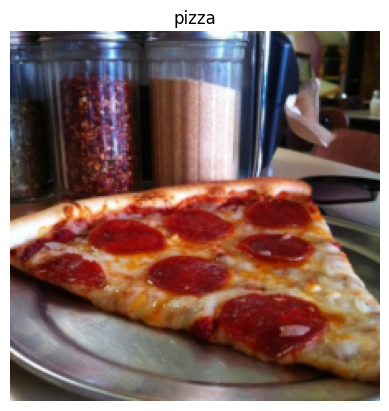

In [116]:
# View single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [117]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels_ height, width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we've passed a single image to our `conv2d` layer, it's shape is:

```Python
torch.Size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Showing random convolutional feature mapsfrom indexes: [461, 115, 120, 537, 557]
461
115
120
537
557


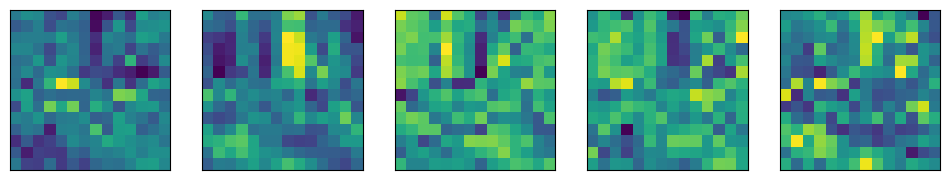

In [118]:
# Plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k = 5)
print(f"Showing random convolutional feature mapsfrom indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows = 1, ncols=5, figsize=(12, 12))

3 # Plot random image feature maps
for i, idx in enumerate(random_indexes):
  print(idx)
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) #remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
  axs[i].set(xticklabels=[], yticklabels=[], xticks = [], yticks = [])

In [119]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.1778, -0.1660, -0.1734, -0.4686, -0.2520, -0.2084, -0.2340,
           -0.4387, -0.4826, -0.1999, -0.1254, -0.2349, -0.1252, -0.0279],
          [-0.1697, -0.2285, -0.2024, -0.3314, -0.2683, -0.2600, -0.3717,
           -0.3629, -0.3910, -0.1886, -0.0211, -0.1828, -0.0347, -0.0476],
          [-0.0545, -0.0673, -0.1172, -0.3549, -0.1946, -0.1576, -0.3271,
           -0.6080, -0.4618, -0.1392, -0.2132, -0.2340, -0.0776, -0.1483],
          [-0.1229, -0.0697, -0.1127, -0.1949, -0.2420, -0.1354, -0.3250,
           -0.6032, -0.4629, -0.2077, -0.1720, -0.4826, -0.1435, -0.0645],
          [-0.1104, -0.0333, -0.1066, -0.3719, -0.3320, -0.1077, -0.3101,
           -0.6376, -0.3879, -0.2745, -0.2989, -0.1964, -0.1508, -0.1455],
          [-0.1327, -0.0093, -0.0787, -0.3273, -0.2004, -0.1330, -0.2433,
           -0.5038, -0.5045, -0.2555, -0.3853, -0.1398, -0.2043, -0.1629],
          [-0.1749, -0.1637, -0.3289, -0.4752, -0.4751, -0.3976, -0.4050,
           -0.3949, -0.3189, -0.

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Right now we've got a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence to satisfy the input criteria  of the ViT trandformer Encoder.

In [120]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width


Want: (batch_size, number_of_patches, embedding_dim)

In [121]:
from torch import nn
flatten_layer = nn.Flatten(start_dim = 2, # feature_map_height
                           end_dim = 3) # feature_map_weight

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature maps (pathces) shape: torch.Size([1, 768, 14, 14])
Flatten image feature map shape: torch.Size([1, 768, 196])


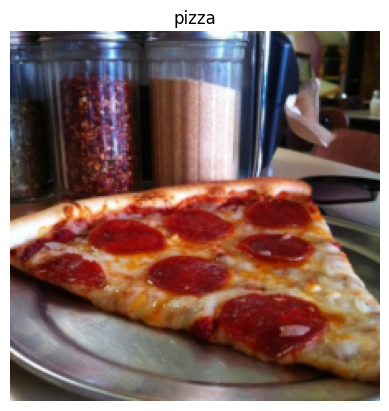

In [122]:
# Put everything together
plt.imshow(image.permute(1 ,2 , 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature_maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension
print(f"Image feature maps (pathces) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flatten image feature map shape: {image_out_of_conv_flattened.shape}")

In [123]:
# Rearrange out put of flatten layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_patches, embedding_dim")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dim


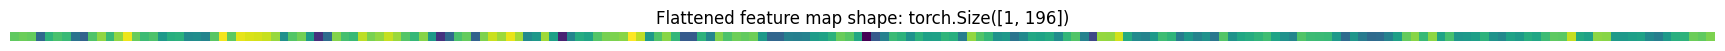

In [124]:
# Get a sinvle flattened feature layer
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0] # we want the first dimension
single_flattened_feature_map

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.axis(False);

Challenge: Convert out flattened layer into a single PyTorch layer so that we could just pass it

### 4.5 Turning a ViT patch embedding layer into a PyTorch module

We want this module few things:
1. Create  class called `PatchEmbeddig` that inherits from `nn.Module`.
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedded patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of th eoutput of the layer in 3.
5. Define a `forward()` that defines the forward computation (e.g. pass through layer from 3 and 4).
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [125]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [126]:
# # 1. Create a class that inherits from nn.Module
# class multiheadSelfAttentionBlock(nn.Module):
#     """Creates a multi-head self-attention block ("MSA block" for short).
#     """
#     # 2. Initialize the class with hyperparameters from Table 1
#     def __init__(self,
#                  embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
#                  num_heads:int=12, # Heads from Table 1 for ViT-Base
#                  attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
#         super().__init__()

#         # 3. Create the Norm layer (LN)
#         self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

#         # 4. Create the Multi-Head Attention (MSA) layer
#         self.multihead_attn = nn.multiheadAttention(embed_dim=embedding_dim,
#                                                     num_heads=num_heads,
#                                                     dropout=attn_dropout,
#                                                     batch_first=True) # does our batch dimension come first?

#     # 5. Create a forward() method to pass the data throguh the layers
#     def forward(self, x):
#         x = self.layer_norm(x)
#         attn_output, _ = self.multihead_attn(query=x, # query embeddings
#                                              key=x, # key embeddings
#                                              value=x, # value embeddings
#                                              need_weights=False) # do we need the weights or just the layer outputs?
#         return attn_output

In [127]:
from torch import nn

# 1.
class PatchEmbedding(nn.Module):
  # 2.
  def __init__(self,
               in_channels:int = 3,
               embedding_dimension:int=768,
               patch_size:int=16
           ):

    super().__init__()

    self.patch_size = patch_size

    # 3.
    self.patcher = (
        nn.Conv2d(in_channels=in_channels, # for color images
                  out_channels=embedding_dimension, # D size from Table 1 for ViT base to begin with
                  kernel_size=patch_size,
                  stride=patch_size,
                  padding=0)
    )

    # 4.
    self.flatten = nn.Flatten(start_dim = 2, # feature_map_height
                           end_dim = 3) # feature_map_weight

  # 5.
  def forward (self, x):
    # Create assertion
    image_resolution = x.shape[-1]
    assert  image_resolution % patch_size== 0, f"Input image size must be divisible by patch size, image shape:{image_resolution}, patch size: {patch_size}"

    # Perfom the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # 6.
    return x_flattened.permute(0,2,1)


In [128]:
set_seeds()

patchify = PatchEmbedding(in_channels = 3,
                          patch_size = 16,
                          embedding_dimension=768)

print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [129]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

# patchify(rand_image_tensor_bad)

### 4.6 Creating the class toen embedding
Want to: prepend a leanable class toekn to start of the patch embedding

In [130]:
patch_embedded_image

tensor([[[-0.2074, -0.1375, -0.1208,  ...,  0.1601, -0.1834,  0.2238],
         [-0.2933,  0.0617, -0.1270,  ...,  0.1887, -0.0210,  0.0562],
         [-0.2261,  0.0680, -0.0855,  ...,  0.1759, -0.0807,  0.0865],
         ...,
         [-0.3421,  0.0533, -0.1906,  ...,  0.2012, -0.0500,  0.1973],
         [-0.3252,  0.0593, -0.2030,  ...,  0.2047, -0.0696,  0.1434],
         [-0.2129,  0.0206, -0.2308,  ...,  0.1335,  0.0009,  0.1901]]],
       grad_fn=<PermuteBackward0>)

In [131]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [132]:
# Create class token embedding as a learnable parameter that shares size as the embedding dimension (D)
class_token  = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                            requires_grad = True)
class_token.shape, class_token[:,:,:10]

(torch.Size([1, 1, 768]),
 tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>))

In [133]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # number_of_patches dimension

print(patch_embedded_image_with_class_embedding.shape)
print(patch_embedded_image_with_class_embedding)

torch.Size([1, 197, 768])
tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-2.0745e-01, -1.3747e-01, -1.2084e-01,  ...,  1.6012e-01,
          -1.8340e-01,  2.2381e-01],
         [-2.9327e-01,  6.1658e-02, -1.2702e-01,  ...,  1.8873e-01,
          -2.0976e-02,  5.6191e-02],
         ...,
         [-3.4210e-01,  5.3266e-02, -1.9055e-01,  ...,  2.0122e-01,
          -5.0025e-02,  1.9731e-01],
         [-3.2516e-01,  5.9344e-02, -2.0297e-01,  ...,  2.0466e-01,
          -6.9599e-02,  1.4335e-01],
         [-2.1291e-01,  2.0638e-02, -2.3078e-01,  ...,  1.3355e-01,
           9.2059e-04,  1.9013e-01]]], grad_fn=<CatBackward0>)


### 4.7 Creating the position embedding

Want to: create a series of 1D learnable position embeddings and to add them to the sequence of the patch embeddings

In [134]:
# View the squnce of the patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding.shape, patch_embedded_image_with_class_embedding


(torch.Size([1, 197, 768]),
 tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
            1.0000e+00,  1.0000e+00],
          [-2.0745e-01, -1.3747e-01, -1.2084e-01,  ...,  1.6012e-01,
           -1.8340e-01,  2.2381e-01],
          [-2.9327e-01,  6.1658e-02, -1.2702e-01,  ...,  1.8873e-01,
           -2.0976e-02,  5.6191e-02],
          ...,
          [-3.4210e-01,  5.3266e-02, -1.9055e-01,  ...,  2.0122e-01,
           -5.0025e-02,  1.9731e-01],
          [-3.2516e-01,  5.9344e-02, -2.0297e-01,  ...,  2.0466e-01,
           -6.9599e-02,  1.4335e-01],
          [-2.1291e-01,  2.0638e-02, -2.3078e-01,  ...,  1.3355e-01,
            9.2059e-04,  1.9013e-01]]], grad_fn=<CatBackward0>))

In [135]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                              number_of_patches + 1,
                                              embedding_dimension),
                                   requires_grad = True)
position_embedding.shape, position_embedding

(torch.Size([1, 197, 768]),
 Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True))

In [136]:
# Add the posiotion embedding to the patch and class rolen embedding
patch_and_position_embedding  = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding.shape, patch_and_position_embedding

(torch.Size([1, 197, 768]),
 tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.7926, 0.8625, 0.8792,  ..., 1.1601, 0.8166, 1.2238],
          [0.7067, 1.0617, 0.8730,  ..., 1.1887, 0.9790, 1.0562],
          ...,
          [0.6579, 1.0533, 0.8094,  ..., 1.2012, 0.9500, 1.1973],
          [0.6748, 1.0593, 0.7970,  ..., 1.2047, 0.9304, 1.1434],
          [0.7871, 1.0206, 0.7692,  ..., 1.1335, 1.0009, 1.1901]]],
        grad_fn=<AddBackward0>))

### 4.8 Putting it all together: from image to embedding

We've written code to turn an image into a flattened sequence of patch embeddings.

In [137]:
set_seeds()

patch_size = 16

print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels = 3,
                                       patch_size=patch_size,
                                       embedding_dimension=768)

# Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token  = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                            requires_grad = True) # Make sure it's learnable



print(f"Class token embedding shape: {class_token.shape}")


# Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # number_of_patches dimension
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# Create position embedding
number_of_patches = int((height*width)/ patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                   requires_grad=True)

# Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Equation 2: multihead Self-Attention (MSA block)

* multihead self-attention: which part of a seqeunce should pay the most attention to itself?

  * In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
  * We want out neural network (ViT) to learn this relationship/representation.
* To replicate MSA on PyTorh we can use: https://pytorch.org/docs/stable/generated/torch.nn.multiheadAttention.html
* LayerNorm - A technique to normalize the distributions of intermediate layers. it enables smoother gradients, faster trainig, and better generalization accuracy
 * Normalization = Make everything have the same mean and same standard devation.
 * In PyTorch = https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html#torch.nn.LayerNorm, normalizes values over $D$ dimesions, in our case, the $D$ dimesion is the embedding dimension.
 * When we normalize along the embedding dimension, it's like makng all the stairs in a staircase the same size



In [138]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [139]:
# # Create an instance of MSABlock
# multihead_self_attention_block = multiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
#                                                              num_heads=12) # from Table 1

# # Pass patch and position image embedding through MSABlock
# patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
# print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
# print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

In [140]:
# Create an instance MSA block
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim = 768,
                                                             num_heads=12)
# Pass th epatch and position image embedding sequence through MSA block
patched_image_through_msa_block  = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


## 6. Equation 3: Multilayer Perceptron (MLP block)

* **MLP** = The MLP cintains two layers with a GELU non-linearity (section 3.1).
  * MLP = a quite broad term for a block with series of layer(s), layers can be multiple or even only on hidden layer.
  * Layers can mean fully-connected, dende, linear, feed-forward, all are oftn  similar names fo the same thing. In PyTorch, they're often claled `torch.nn.Linear()` and in TensorFlow they might be called `tf.keras.layers.Dense()`
  * GELU in PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.GELU.html


* **Dropout**: When used, is applied after every dense ;ayer except for the qkv-projections and directly after adding positional-to-patch embeddings. Hybris models atr trained with the exact setup as their ViT counterparts.
  * Value of dropout available in table 3
In Pseudocode:
```Python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```

In [141]:
class MLPBLock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:int = 0.1):

    super().__init__()

    # Create the norm layer
    self.layerNorm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)


    )

  def forward (self, x):
    x = self.layerNorm(x)
    x = self.mlp(x)
    return x

In [142]:
# Create an instance of MLPBlock
mlp_block = MLPBLock(embedding_dim=768,
               mlp_size=3072,
               dropout= 0.1)
# Pass output the MSABlock through MLPBLock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_mlp_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_msa_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


In [143]:
patched_image_through_mlp_block[:6,:6,:6], patched_image_through_msa_block[:6,:6,:6]

(tensor([[[-6.5533e-02,  1.1090e-04,  1.6668e-01,  2.0459e-01, -1.4084e-01,
           -2.8073e-01],
          [-1.1360e-01, -1.3329e-01,  2.6338e-01,  7.6557e-02, -0.0000e+00,
           -5.2970e-02],
          [-3.7776e-02, -3.4603e-02,  3.0078e-01,  1.3536e-01, -1.6200e-01,
           -2.3969e-01],
          [-3.3959e-02, -1.5017e-03,  2.7257e-01,  1.3271e-01, -3.8396e-02,
            1.6234e-02],
          [-8.7716e-02, -8.8348e-02,  0.0000e+00,  5.3028e-02, -9.8193e-02,
           -5.5832e-02],
          [ 0.0000e+00, -7.4081e-02,  1.8565e-01,  9.9572e-02, -1.0231e-01,
           -8.7797e-02]]], grad_fn=<SliceBackward0>),
 tensor([[[-0.2262, -0.2347,  0.0789,  0.1737, -0.1664, -0.0471],
          [-0.2254, -0.2047,  0.0798,  0.1585, -0.1771, -0.0425],
          [-0.2249, -0.2136,  0.0888,  0.1471, -0.1768, -0.0523],
          [-0.2257, -0.2152,  0.0853,  0.1483, -0.1815, -0.0541],
          [-0.2266, -0.2255,  0.0855,  0.1431, -0.1864, -0.0571],
          [-0.2242, -0.2030,  0.079

## 7. Creating the Transformer Encoder

The Transformer Encoder is a combination of alternating blocks of MSA (equation 2) and MLP.
And there are residuals connections between each block.

* Encoder = Turn a sequence into learnable representation
* Decoder = go from learn representation back to home sort of sequence
* Residual connection - add a layer(s) input to its subsequent output, this enables the creation deeper netweorks (prevents weights from getting too small)
In pseudocode:
```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_outout + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

### 7.1 Create a custom Transformer Encoder Block

In [144]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = multiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [145]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768, # Table 1
               num_heads:int=12, # Table 1
               mlp_size:int = 3072, # Table 1
               mlp_dropout:float=0.1, # Table 3
               attn_dropout:float=0):
    super().__init__()

    # Create MSA Block (equation 2)
    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    # Create MLP block (equation 3)
    self.mlp_block = MLPBLock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward (self, x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x

In [146]:
# Create an instance TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# print a summary using torchinfo summary
summary(model=transformer_encoder_block,
        input_size = (1, 197, 768),
        col_names = ["input_size","output_size", "num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBLock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layerNorm)                       [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a Transfomer Encoder layer with in-buily PyTorch layers

So far we've created a trnsformer encoder by hand.

But because of how good the Transfomer architecture is, PyTorch has implemented ready to use Transformer Encoder layers:
https://pytorch.org/docs/stable/nn.html#transformer-layers

We can create a Transformer Encoder with pure PyTorch layers:
https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#


In [147]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first = True,
                                                             norm_first=True)

torch_transformer_encoder_layer



TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [148]:


# Print a summary using torchinfo summary
summary(model=torch_transformer_encoder_layer,
        input_size = (1, 197, 768),
        col_names = ["input_size","output_size", "num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

Why spend all this time recreating the transformer encoder when we could've just made a single PyTorch layer?

Practice. Practice. Practice.

Now we know how things are implemented behimde the scened, we can tweak them if necessary.

What are the benefits of using a pre-built PyTorch  layer?
* Less prone to errors
* Potential benefit of speed ups (performance boosts)

## 8. Putting it all together to create ViT

In [149]:
# Create a Vit class
class ViT(nn.Module):
  def __init__(self,
               img_size:int=224,
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12,
               embedding_dim:int=768,
               mlp_size:int=3072,
               num_heads:int=12,
               attn_dropout:float=0,
               mlp_dropout:float = 0.1,
               embedding_dropout:float=0.1,
               num_classes:int = 1000 #3 number of classes on out clasification problem
               ):
    super().__init__()

    assert img_size % patch_size == 0, f"Input image size must be divisible by patch size, image shape:{img_size}, patch size: {patch_size}"

    # Calculate N (number of patches)
    self.number_of_patches = (img_size * img_size) // patch_size**2

    # Get the embedding dimension

    self.embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

    # Create learnable class embeddings (needs to go at front of sequrnce of patch embeddings)
    self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                      requires_grad = True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(torch.randn(1, self.number_of_patches+1, embedding_dim))


    # Create embedding dropout value
    self.embedding_droput = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                         patch_size=patch_size,
                        embedding_dimension=embedding_dim)

    # Create the Transformer Encoder Block
    self.tranformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                      num_heads=num_heads,
                                                                      mlp_size = mlp_size,
                                                                      mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])


    # Create a classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
    )

  def forward(self, x):
    # Get the batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # '-1' mean to infer the dimensions

    x = self.patch_embedding(x)

    # Concat class token embedding and patch embedding
    x = torch.concat((class_token, x), dim=1)

    x = self.position_embedding + x

    x = self.embedding_droput(x)

    x = self.tranformer_encoder(x)

    # Put 0th index logit through classifier (equation 4)
    x = self.classifier(x[:, 0])
    return x

In [150]:
vit = ViT()
vit

ViT(
  (embedding_droput): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (tranformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiheadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBLock(
        (layerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (

In [151]:
set_seeds()


# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=(len(class_names)))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of our ViT model

In [152]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=ViT(num_classes=1000),
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        # # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 1000]            152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_droput)                                 [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (tranformer_encoder)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## 9. Setting up training code for our custom ViT
We've replicated the ViT architecture, now let's see how it performs pn our FoodVision Mini data.


### 9.1 Creating an optimizer

The paper states it uses the Adam optimizer 9section 4, Training & fine Tuning with $B$ value of 0.9, $B2$ of 0.999 (defaults) and a  weight deca of 0.1.

Weight decay - Regularization technique used in training neural networks to prevent overfitting by penalizing large weights.

In [168]:
optimizer = torch.optim.Adam(vit.parameters(),
                             lr=0.3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

### 9.2 Creating a loss function

The ViT paper doesn't actually mention what loss function they used

So since it's a multi-class classification we'll use the `torch.nn.CrossEntropyLoss()`.

In [169]:
loss_fn = torch.nn.CrossEntropyLoss()

### 9.3 Training our ViT Model

In [170]:
from going_modular.going_modular import engine

set_seeds()

results = engine.train(model = vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=20,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 44.5236 | train_acc: 0.4062 | test_loss: 45.4433 | test_acc: 0.5417
Epoch: 2 | train_loss: 50.2259 | train_acc: 0.2773 | test_loss: 27.9442 | test_acc: 0.1979
Epoch: 3 | train_loss: 15.1042 | train_acc: 0.3359 | test_loss: 38.2871 | test_acc: 0.2604
Epoch: 4 | train_loss: 21.9069 | train_acc: 0.2578 | test_loss: 14.6843 | test_acc: 0.1979
Epoch: 5 | train_loss: 32.2327 | train_acc: 0.2461 | test_loss: 5.3754 | test_acc: 0.5417
Epoch: 6 | train_loss: 29.9429 | train_acc: 0.2812 | test_loss: 61.7653 | test_acc: 0.1979
Epoch: 7 | train_loss: 39.7785 | train_acc: 0.3086 | test_loss: 9.5735 | test_acc: 0.2604
Epoch: 8 | train_loss: 19.5309 | train_acc: 0.3125 | test_loss: 25.9303 | test_acc: 0.2396
Epoch: 9 | train_loss: 26.5447 | train_acc: 0.2969 | test_loss: 11.0490 | test_acc: 0.5417
Epoch: 10 | train_loss: 14.5166 | train_acc: 0.3594 | test_loss: 18.3817 | test_acc: 0.2604
Epoch: 11 | train_loss: 15.6687 | train_acc: 0.3828 | test_loss: 21.7760 | test_acc: 0.2907

### 9.4 How is our different training setup to the ViT paper?

We've replicated model architecture correctly.

But what was different between our training precdure (to get such poor results) and ViT paper training implementation is missing:

* Prevent underfitting:
 * Data - our setup uses far less data (225 vs. millions)

* Prevent overfitting:
 * Learning rate warmup - start with a low learning rate and increase to a base LR
 * Learning reate decay - as your model gets closer to convergence, start to lower the learning rate
 * Gradient clipping - prevent gradients from getting too big

### 9.5 Plotting loss curves od our model

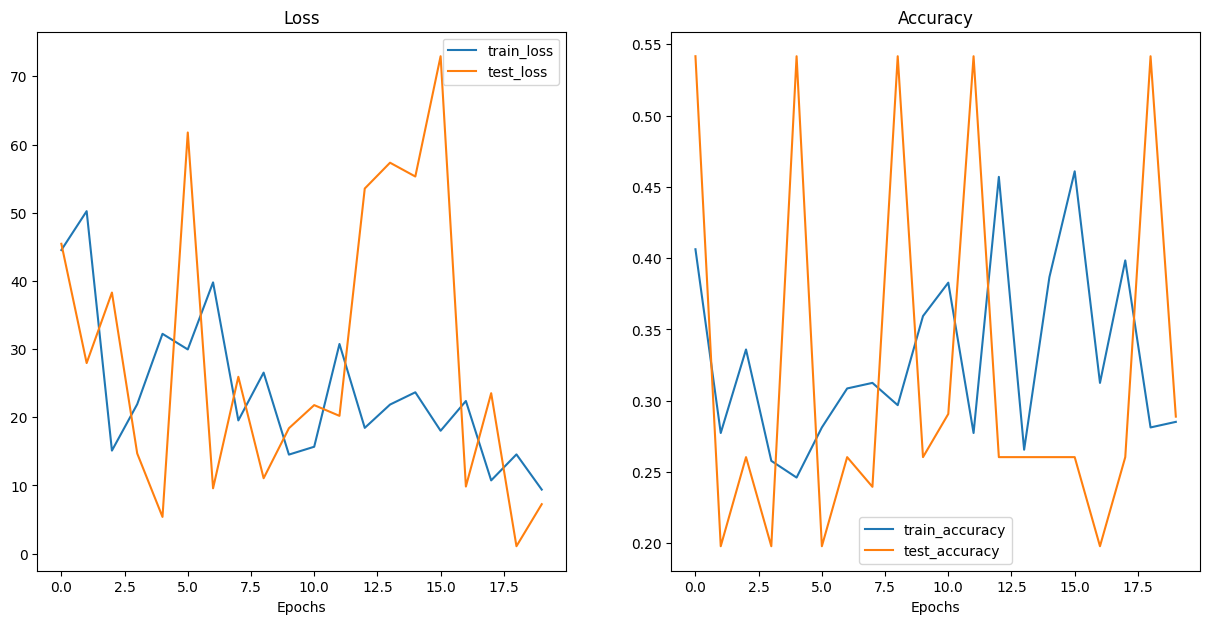

In [171]:
plot_loss_curves(results)

## 10. Using a pretrained ViT from `torchvision.models`

### 10.1 Why use a pretrained model?

* Sometimes data is limited
* Limited training results
* Get better results faster (sometimes)...

### 10.2 Prepare a pretrained ViT for use with FooBision Mini (turn it into a feature extractor)

In [158]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [159]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

### 10.3 Preparing data for pretrained ViT model

In [160]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [161]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [162]:

# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)

### 10.4 Train feature extactor ViT model

In [163]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


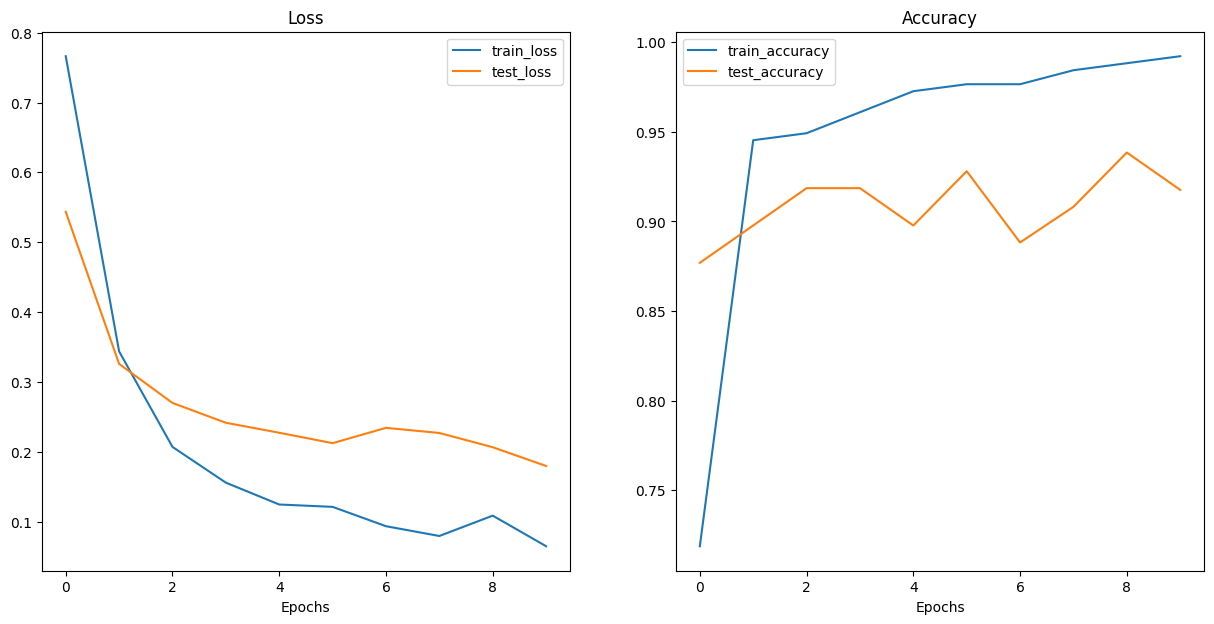

In [164]:
plot_loss_curves(pretrained_vit_results)

### 10.6 Save our best performing ViT model

In [165]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [166]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


## 11. Predicting on a custom image

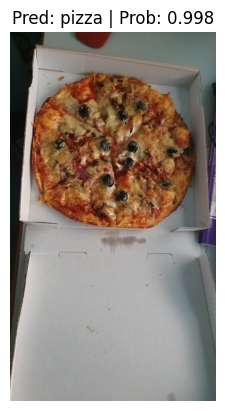

In [167]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "my_pizza.jpg"

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)